# Machine Learning Trading Bot

## Background
- Three machine learning models were utilized to train and predict the trading data sourced from Alpaca API. 
- The target was determined to be the entry price plus 3 times the Average True Range(ATR): '1'.
- The stop was determined to be the entry price minus the Average True Range (ATR): '-1'. 
- Support Vector Machine (SVM), Decision Tree models, and Stochasstic Gradient Descent (SGD) were applied to this data.

In [1]:
# initial imports
from pathlib import Path 
import numpy as np
import matplotlib.pyplot as plt 
from finta import TA

import pandas as pd 
import hvplot.pandas
from pandas.tseries.offsets import DateOffset

import alpaca_trade_api as tradeapi

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn import svm

from imblearn.under_sampling import RandomUnderSampler

In [2]:
import alpaca
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime
from dateutil.relativedelta import relativedelta

trading_pair = "ETH/USD"
time_diff = datetime.now() - relativedelta(days=600)

# Alpaca Market Data Client
data_client = CryptoHistoricalDataClient()

# Defining Bar data request parameters
request_params = CryptoBarsRequest(
    symbol_or_symbols=[trading_pair],
    timeframe=TimeFrame(5, alpaca.data.timeframe.TimeFrameUnit.Minute),
    start=time_diff
)

# Get the bar data from Alpaca
signals_df = data_client.get_crypto_bars(request_params).df

signals_df

open       high        low      close  \
symbol  timestamp                                                               
ETH/USD 2022-01-18 17:05:00+00:00  3120.0000  3121.2500  3113.4400  3118.8100   
        2022-01-18 17:10:00+00:00  3118.0400  3122.4800  3115.0100  3120.5400   
        2022-01-18 17:15:00+00:00  3121.6900  3129.8800  3115.3500  3126.3900   
        2022-01-18 17:20:00+00:00  3127.9600  3130.2000  3119.7200  3120.9700   
        2022-01-18 17:25:00+00:00  3120.6400  3123.1600  3113.9900  3113.9900   
...                                      ...        ...        ...        ...   
        2023-09-10 21:40:00+00:00  1622.8200  1622.8200  1622.1835  1622.2550   
        2023-09-10 21:45:00+00:00  1622.4815  1623.5600  1621.0310  1621.0310   
        2023-09-10 21:50:00+00:00  1621.3635  1622.3470  1620.8105  1622.2350   
        2023-09-10 21:55:00+00:00  1621.9700  1623.0500  1621.9205  1623.0215   
        2023-09-10 22:00:00+00:00  1623.5105  1623.5105  1621.8130  1621.8130   

                                     volume  trade_count         vwap  
symbol  timestamp                                                      
ETH/USD 2022-01-18 17:05:00+00:00  66.88957        167.0  3116.475162  
        2022-01-18 17:10:00+00:00  24.53026         94.0  3119.228469  
        2022-01-18 17:15:00+00:00  32.10385        127.0  3122.046115  
        2022-01-18 17:20:00+00:00  24.01851         80.0  3127.591885  
        2022-01-18 17:25:00+00:00  28.79192         98.0  3118.080281  
...                                     ...          ...          ...  
        2023-09-10 21:40:00+00:00   0.00000          0.0     0.000000  
        2023-09-10 21:45:00+00:00   0.00000          0.0     0.000000  
        2023-09-10 21:50:00+00:00   0.00000          0.0     0.000000  
        2023-09-10 21:55:00+00:00   0.00000          0.0     0.000000  
        2023-09-10 22:00:00+00:00   0.00000          0.0     0.000000  

[172725 rows x 7 columns]

### Download stock time-series data from Alpaca API into Pandas DataFrame

In [3]:
# THE FOLLOWING IS TO REQUEST IN DATA USING THE ALPACA_API
# API credentials
API_KEY = 'PKD98H4EZF8YRDLUZ5I2'
SECRET_KEY = 'b5ZbNnx35m3uaB6vRnrU7TLQlgEfDw0bKf1Y8Zsm'
API_BASE_URL = "https://paper-api.alpaca.markets"

# Create a connection to the API 
api = tradeapi.REST(API_KEY, SECRET_KEY, API_BASE_URL, api_version="v2")
    
# Set the ticket symbol and the number of shares to buy
ticker = "AAPL"

# Make API call
signals_df = api.get_bars(ticker, "5Min", "2022-01-01", "2023-08-30", adjustment='raw').df

# Save the DataFrame with the date index
signals_df.to_csv('AAPL_time_series_df.csv')

# create a seperate dataframe for signals
signals_df

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2022-01-03 09:00:00+00:00,178.26,178.34,178.15,178.15,6894,235,178.243947
2022-01-03 09:05:00+00:00,178.20,178.20,177.76,177.99,4767,186,177.958045
2022-01-03 09:10:00+00:00,177.91,178.08,177.90,178.08,3598,120,177.952941
2022-01-03 09:15:00+00:00,178.08,178.12,177.81,177.86,8398,207,177.998975
2022-01-03 09:20:00+00:00,178.02,178.02,178.00,178.00,1369,72,178.007063
...,...,...,...,...,...,...,...
2023-08-30 23:35:00+00:00,187.65,187.66,187.65,187.66,5373,110,187.654376
2023-08-30 23:40:00+00:00,187.65,187.66,187.64,187.64,6379,124,187.656366
2023-08-30 23:45:00+00:00,187.65,187.65,187.63,187.65,1380,68,187.640261


### Read in stock time-series data from .csv file into Pandas DataFrame

In [4]:
# # Set ticker
# ticker = "AAPL"

# # Load the DataFrame from a CSV file
# signals_df = pd.read_csv('AAPL_time_series_df.csv', index_col="timestamp")

# # Convert the first column (assuming it contains datetime-like values) to DatetimeIndex
# signals_df.index = pd.to_datetime(signals_df.index)

# Define NYSE regular trading hours
nyse_opening_time = pd.Timestamp("09:30:00")
nyse_closing_time = pd.Timestamp("16:00:00")

# Filter the DataFrame to include only data within NYSE regular trading hours
signals_df = signals_df.between_time(nyse_opening_time.time(), nyse_closing_time.time())

# save copy
signals_df.to_csv("ETH_time_series_df.csv", index="timestamp")

signals_df

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2022-01-03 09:30:00+00:00,177.8700,177.870,177.76,177.8500,3739,157,177.810011
2022-01-03 09:35:00+00:00,177.8500,177.880,177.77,177.7700,5849,141,177.820198
2022-01-03 09:40:00+00:00,177.8300,177.890,177.81,177.8900,5828,106,177.854315
2022-01-03 09:45:00+00:00,177.8800,178.010,177.81,178.0100,4805,129,177.877559
2022-01-03 09:50:00+00:00,177.9600,178.060,177.92,178.0600,4659,84,177.969515
...,...,...,...,...,...,...,...
2023-08-30 15:40:00+00:00,187.1700,187.330,187.10,187.2100,520662,5116,187.198690
2023-08-30 15:45:00+00:00,187.2100,187.225,187.02,187.0421,410374,4126,187.151151
2023-08-30 15:50:00+00:00,187.0500,187.080,186.95,187.0000,483145,4889,187.011434


<Axes: title={'center': 'AAPL Closing Prices'}, xlabel='Timestamp', ylabel='Closing Price'>

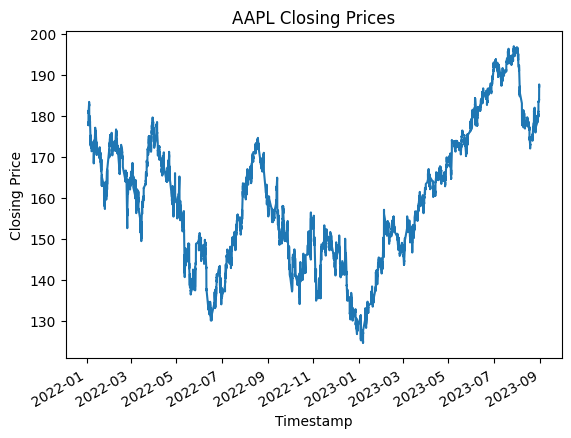

In [5]:
# plot closing prices
signals_df['close'].plot(title=f'{ticker} Closing Prices', xlabel="Timestamp", ylabel='Closing Price')
# plt.savefig(f'{ticker}_closing_prices', facecolor='white', edgecolor='white', transparent='false')

### Add Features (Techincal Analysis Indicators) to the DataFrame

In [6]:
# continuous features (techinal indicators) may be used
features = ["volume", "trade_count", "vwap", "9EMA", "20EMA", "50EMA", "200SMA", "ATR", "RSI", "BB_UPPER", "BB_LOWER", "MACD"]

#  Setup EMAs for crosses
longest_MA_window = 200
signals_df["9EMA"] = TA.EMA(signals_df, 9)
signals_df["20EMA"] = TA.EMA(signals_df, 20)
signals_df["50EMA"] = TA.EMA(signals_df, 50)
signals_df["200SMA"] = TA.SMA(signals_df, longest_MA_window)

# Setup Indicators
signals_df["ATR"] = TA.ATR(signals_df)
bbands_df = TA.BBANDS(signals_df)
macd_df = TA.MACD(signals_df)
signals_df["RSI"] = TA.RSI(signals_df)

# join macd and bbands Dataframes to signals_df
bbands_df = pd.concat([bbands_df, macd_df], axis=1)
signals_df = pd.concat([signals_df, bbands_df], axis=1)
signals_df.drop(columns="SIGNAL", inplace=True)

# Exit is the labeled target for ML, Exit Price is for use in Pnl Metrics
signals_df["Exit Price"] = 0
signals_df["Exit"] = 0

# Review DataFrame
signals_df

C:\Users\range\AppData\Local\Temp\ipykernel_12640\1529371452.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals_df["9EMA"] = TA.EMA(signals_df, 9)
C:\Users\range\AppData\Local\Temp\ipykernel_12640\1529371452.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals_df["20EMA"] = TA.EMA(signals_df, 20)
C:\Users\range\AppData\Local\Temp\ipykernel_12640\1529371452.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

,open,high,low,close,volume,trade_count,vwap,9EMA,20EMA,50EMA,200SMA,ATR,RSI,BB_UPPER,BB_MIDDLE,BB_LOWER,MACD,Exit Price,Exit
timestamp,,,,,,,,,,,,,,,,,,,
2022-01-03 09:30:00+00:00,177.8700,177.870,177.76,177.8500,3739,157,177.810011,177.850000,177.850000,177.850000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0,0
2022-01-03 09:35:00+00:00,177.8500,177.880,177.77,177.7700,5849,141,177.820198,177.805556,177.808000,177.809200,NaN,NaN,0.000000,NaN,NaN,NaN,-0.001795,0,0
2022-01-03 09:40:00+00:00,177.8300,177.890,177.81,177.8900,5828,106,177.854315,177.840164,177.838110,177.837218,NaN,NaN,61.764706,NaN,NaN,NaN,0.001434,0,0
2022-01-03 09:45:00+00:00,177.8800,178.010,177.81,178.0100,4805,129,177.877559,177.897696,177.887732,177.883039,NaN,NaN,77.038043,NaN,NaN,NaN,0.007200,0,0
2022-01-03 09:50:00+00:00,177.9600,178.060,177.92,178.0600,4659,84,177.969515,177.945978,177.929402,177.921318,NaN,NaN,80.528228,NaN,NaN,NaN,0.012171,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-30 15:40:00+00:00,187.1700,187.330,187.10,187.2100,520662,5116,187.198690,186.830807,186.541032,185.685757,182.061526,0.328286,67.275124,187.399987,186.693815,185.987643,0.383296,0,0
2023-08-30 15:45:00+00:00,187.2100,187.225,187.02,187.0421,410374,4126,187.151151,186.873065,186.588753,185.738947,182.101236,0.319536,63.065404,187.427880,186.705920,185.983960,0.377953,0,0
2023-08-30 15:50:00+00:00,187.0500,187.080,186.95,187.0000,483145,4889,187.011434,186.898452,186.627919,185.788400,182.139937,0.296000,62.017482,187.273647,186.674810,186.075973,0.366101,0,0


In [7]:
# Define NYSE regular trading hours
nyse_opening_time = pd.Timestamp("09:30:00")
nyse_closing_time = pd.Timestamp("16:00:00")

# Filter the DataFrame to include only data within NYSE regular trading hours
signals_df = signals_df.between_time(nyse_opening_time.time(), nyse_closing_time.time())

# Review DataFrame
signals_df

,open,high,low,close,volume,trade_count,vwap,9EMA,20EMA,50EMA,200SMA,ATR,RSI,BB_UPPER,BB_MIDDLE,BB_LOWER,MACD,Exit Price,Exit
timestamp,,,,,,,,,,,,,,,,,,,
2022-01-03 09:30:00+00:00,177.8700,177.870,177.76,177.8500,3739,157,177.810011,177.850000,177.850000,177.850000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0,0
2022-01-03 09:35:00+00:00,177.8500,177.880,177.77,177.7700,5849,141,177.820198,177.805556,177.808000,177.809200,NaN,NaN,0.000000,NaN,NaN,NaN,-0.001795,0,0
2022-01-03 09:40:00+00:00,177.8300,177.890,177.81,177.8900,5828,106,177.854315,177.840164,177.838110,177.837218,NaN,NaN,61.764706,NaN,NaN,NaN,0.001434,0,0
2022-01-03 09:45:00+00:00,177.8800,178.010,177.81,178.0100,4805,129,177.877559,177.897696,177.887732,177.883039,NaN,NaN,77.038043,NaN,NaN,NaN,0.007200,0,0
2022-01-03 09:50:00+00:00,177.9600,178.060,177.92,178.0600,4659,84,177.969515,177.945978,177.929402,177.921318,NaN,NaN,80.528228,NaN,NaN,NaN,0.012171,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-30 15:40:00+00:00,187.1700,187.330,187.10,187.2100,520662,5116,187.198690,186.830807,186.541032,185.685757,182.061526,0.328286,67.275124,187.399987,186.693815,185.987643,0.383296,0,0
2023-08-30 15:45:00+00:00,187.2100,187.225,187.02,187.0421,410374,4126,187.151151,186.873065,186.588753,185.738947,182.101236,0.319536,63.065404,187.427880,186.705920,185.983960,0.377953,0,0
2023-08-30 15:50:00+00:00,187.0500,187.080,186.95,187.0000,483145,4889,187.011434,186.898452,186.627919,185.788400,182.139937,0.296000,62.017482,187.273647,186.674810,186.075973,0.366101,0,0


### Create Volatility Based Targets and Stops

In [8]:
# here we create the exit column, our "y", for use in supervised ML
# How many rows are in the signals_df? for use in modifying DataFrame
num_rows_in_df = signals_df.shape[0]

# reward:risk ratio
reward = 10
risk = 4

# we also figure out our exit price
# hitting target price before the stop price signals a win and will be 1
# hitting stop price before hitting the target price signals a loss and will be -1
# loop thru the dataframe, from the longest_MA_window to the end (num_rows_in_df) to avoid NaN values
for j in range(longest_MA_window, num_rows_in_df):
    # entries will be on candle close
    entry = signals_df["close"].iloc[j]
    # calculate volatility for each candle
    atr = signals_df["ATR"].iloc[j]
    # stop is entry price minus the average volatility for the entry period
    stop = entry - (risk * atr)
    # target is entry price plus the average volatility for the entry period times a multiplier
    target = entry + (reward * atr)
    # loop again thru the dataset to compare j entry price to future closing prices to see if we hit target or stop
    for k in range(j + 1, num_rows_in_df):
        # current low of the candle
        curr_low = signals_df["low"].iloc[k]
        # current high of the candle
        curr_high = signals_df["high"].iloc[k]
        # record and break if we hit stop or target, if not we check the next k period
        # if current low breaks our stop we should've sold: -1 in our "Exit" column
        if curr_low <= stop:
            signals_df.iloc[j, -2] = stop
            signals_df.iloc[j, -1] = -1
            # if we hit the stop break the inner loop to check the next row
            break
        # if current high breaks our target we should've sold: +1 in our "Exit" column
        elif curr_high >= target:
            signals_df.iloc[j, -2] = target
            signals_df.iloc[j, -1] = 1
            # if we hit the target break the inner loop to check the next row
            break

# drop beginning columns to avoid NaN values from EMA/SMA calculations
signals_df = signals_df[longest_MA_window:]

signals_df

C:\Users\range\AppData\Local\Temp\ipykernel_12640\897847839.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '178.49477142857143' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals_df.iloc[j, -2] = stop


KeyboardInterrupt: 

### Data Cleaning

In [ ]:
# remove all unwanted zeros from the exit column
signals_df = signals_df.loc[signals_df["Exit"] != 0]

# # include only higher than average volume
# signals_df = signals_df[signals_df["volume"] >= signals_df["volume"].mean()]

# make sure we have a sufficient training period
training_begin = str(signals_df.index.min())
training_end = str(signals_df.index.min() + DateOffset(months=6))

signals_df

In [ ]:
signals_df.to_csv("cleaned_data.csv", index=True)

### Split the data into training and testing sets.

In [ ]:
# choose features
X = signals_df[features]

# 1 means a buy would've produced a profit (hit target/win), -1 means a sale would've produced a profit (his stop/loss)
y = signals_df["Exit"]
y.head()

In [ ]:
# Splitting into Train and Test sets
X_train = X.loc[training_begin: training_end]
y_train = y.loc[training_begin: training_end]

# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)

In [ ]:
# Scale the data
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
# Undersample the data
rus = RandomUnderSampler(random_state=1)
undersampled_X_train_scaled, undersampled_y_train = rus.fit_resample(X_train_scaled, y_train)

### Support Vector Machine (SVC) Model

In [ ]:
# Create the classifier model
model = svm.SVC(probability=True, random_state=1)
 
# Fit the model to the data using undersampled_X_train_scaled and undersampled_y_train
model = model.fit(undersampled_X_train_scaled, undersampled_y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = model.predict(undersampled_X_train_scaled)
training_probability_estimates = model.predict_proba(undersampled_X_train_scaled)

In [ ]:
import joblib

# Save the trained model to a file
joblib.dump(model, 'AAPL_5MIN_10TO4_SVM.pkl')

In [ ]:
# Save the X_Scaler
joblib.dump(X_scaler, "X_scaler.save") 

In [ ]:
# Evaluate the model using a classification report
training_report = classification_report(undersampled_y_train, training_signal_predictions)
print(training_report)

In [ ]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = model.predict(X_test_scaled)
testing_probability_estimates = model.predict_proba(X_test_scaled)

In [ ]:
# Evaluate the model's ability to predict the trading signal for the testing data
testing_report = classification_report(y_test, testing_signal_predictions)
print(testing_report)

### Visualization

In [ ]:
# Create a predictions DataFrame for SVM
predictions_df = pd.DataFrame(index=X_test.index)

predictions_df["predicted_signal"] = testing_signal_predictions

predictions_df["actual_returns"] = signals_df["close"].pct_change()

predictions_df["algo_returns"] = (signals_df["Exit Price"] - signals_df["close"])/signals_df["close"]


predictions_df["trading_algorithm_returns"] = (
    predictions_df["algo_returns"] * predictions_df["predicted_signal"]
)

predictions_df = predictions_df.drop(columns=["algo_returns"])

predictions_df["probability_estimates"] = testing_probability_estimates[:, 1]

# Filter rows where the predicted signal is 1 and the probability estimate is >= 0.60
buy_signals_df = predictions_df[(predictions_df["predicted_signal"] == 1) & (predictions_df["probability_estimates"] >= 0.50)]


### Evaluation Metrics

In [ ]:
# Calculate the time period for which you want to calculate the frequency (e.g., in days)
start_date = buy_signals_df.index.min()
end_date = buy_signals_df.index.max()
time_period_days = (end_date - start_date).days + 1  # Adding 1 to include both start and end dates

# Filter the winning, losing, and total trades
winning_trades = buy_signals_df[buy_signals_df['trading_algorithm_returns'] > 0]
losing_trades = buy_signals_df[buy_signals_df['trading_algorithm_returns'] < 0]
total_trades = buy_signals_df["trading_algorithm_returns"]

# Calculate gross profit (positive returns) and gross loss (negative returns)
gross_profit = buy_signals_df[buy_signals_df['trading_algorithm_returns'] > 0]['trading_algorithm_returns'].sum() * 100
gross_loss = buy_signals_df[buy_signals_df['trading_algorithm_returns'] < 0]['trading_algorithm_returns'].sum() * 100

# Calculate the average return of your trading strategy
average_return = buy_signals_df['trading_algorithm_returns'].mean()

# Calculate the risk-free rate (e.g., Treasury bill rate)
# You need to specify an appropriate risk-free rate for your analysis
risk_free_rate = 0.02  # Replace with the risk-free rate you want to use (e.g., 2% for a Treasury bill)

# Calculate downside returns (negative returns)
downside_returns = buy_signals_df['trading_algorithm_returns'][buy_signals_df['trading_algorithm_returns'] < 0]

# Calculate the downside deviation (standard deviation of negative returns)
downside_deviation = (downside_returns * 100).std()

# Calculate the Risk:Reward Ratio
risk_reward_ratio= reward/risk

# Calculate the win rate (if you haven't already)
win_rate = len(winning_trades) / len(total_trades)

# Calculate the profit factor
profit_factor = abs(gross_profit / gross_loss)

# Calculate the Sortino Ratio
sortino_ratio = (average_return - risk_free_rate) / downside_deviation

# Calculate the average profit per winning trade
average_profit_per_winning_trade = winning_trades['trading_algorithm_returns'].mean()

# Calculate the average loss per losing trade
average_loss_per_losing_trade = losing_trades['trading_algorithm_returns'].mean()

# Calculate the trade frequency (trades per day)
trade_frequency_per_day = len(total_trades) / time_period_days

# Calculate the volatility of your trading strategy's returns
algo_volatility = buy_signals_df['trading_algorithm_returns'].std()

# Calculate the cumulative returns of the algo
cumulative_returns = ( 1 + buy_signals_df['trading_algorithm_returns']).sum()

# Print the sorted metrics by importance
print("Risk:Reward Ratio:", risk_reward_ratio)
print("Win Rate (%):", win_rate * 100)
print("Profit Factor:", profit_factor)
print("Sortino Ratio:", sortino_ratio)
print("Average Profit per Winning Trade (%):", average_profit_per_winning_trade * 100)
print("Average Loss per Losing Trade (%):", average_loss_per_losing_trade * 100)
print("Average Return (%):", average_return * 100)
print("Trade Frequency (Trades per Day):", trade_frequency_per_day)
print("Downside Deviation:", downside_deviation)
print("Volatility (Standard Deviation of Algo Returns):", algo_volatility)
print("Gross Profit (%):", gross_profit)
print("Gross Loss (%):", gross_loss)
print("Total Number of Winning Trades:", len(winning_trades))
print("Total Number of Trades:", len(total_trades))
print("Risk-Free Rate (%):", risk_free_rate * 100)


### WIP METRICS

In [ ]:
# maximum drawdown (MDD)
# peters ratio
# t-stat
# kelly criterion
# sharpe ratio
# calmar ratio
# pain/gain ratio
# ulcer index
# k-ratio


In [ ]:
# Calculate cumulative returns for the algorithmic trading strategy
buy_signals_df.loc[:, "Cumulative Algo Returns"] = (1 + buy_signals_df.loc[:, "trading_algorithm_returns"]).cumprod()

# Calculate cumulative returns for the actual stock returns
predictions_df.loc[:, "Cumulative Actual Returns"] = (1 + predictions_df.loc[:, "actual_returns"]).cumprod()

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(buy_signals_df.index, buy_signals_df["Cumulative Algo Returns"], label="Algorithm Returns (Buy Signals)")
plt.plot(predictions_df.index, predictions_df["Cumulative Actual Returns"], label="Actual Returns")
plt.xlabel("Date") 
plt.ylabel("Cumulative Returns")
plt.title("Cumulative Returns of Algorithm vs. Actual Returns")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
buy_signals_df

In [ ]:
import pandas as pd

# Assuming your dataframe is named 'buy_signals_df'
# Step 2: Calculate cumulative returns
buy_signals_df['cumulative_returns'] = (1 + buy_signals_df['trading_algorithm_returns']).cumprod()

# Step 3: Calculate the peak
buy_signals_df['peak'] = buy_signals_df['cumulative_returns'].cummax()

# Step 4: Calculate drawdown
buy_signals_df['drawdown'] = buy_signals_df['cumulative_returns'] / buy_signals_df['peak'] - 1

# Step 5: Find the maximum drawdown
max_drawdown = buy_signals_df['drawdown'].min()

print("Maximum Drawdown (MDD): {:.2%}".format(max_drawdown))


In [ ]:
# Calculate Kelly Criterion
kelly_criterion = (win_rate * (average_profit_per_winning_trade / abs(average_loss_per_losing_trade))) - ((1 - win_rate) / abs(average_loss_per_losing_trade))

# Calculate Sharpe Ratio (assuming a risk-free rate has already been defined)
sharpe_ratio = (average_return - risk_free_rate) / algo_volatility

# # Calculate Calmar Ratio
# calmar_ratio = (average_return - risk_free_rate) / (drawdown_max / 100)

# Calculate Pain/Gain Ratio
pain_gain_ratio = (average_loss_per_losing_trade * win_rate) / (average_profit_per_winning_trade * (1 - win_rate))

print(kelly_criterion, sharpe_ratio, pain_gain_ratio)

In [ ]:
import pandas as pd

df2 = pd.DataFrame([{'Risk': 1, 'Reward': 1, 'Win Rate (%)': 51.68067226890757, 'Profit Factor': 1.0733808813416092, 'Cumulative Returns': 1.6981633887097984, 'Sortino Ratio': -0.14363021901285425, 'Average Profit per Winning Trade (%)': 0.19316427176882509, 'Average Loss per Losing Trade (%)': -0.192477609689141, 'Average Return (%)': 0.006824707198799467, 'Trade Frequency (Trades per Day)': 19.4052757793765, 'Downside Deviation': 0.1387713049872061, 'Volatility (Standard Deviation of Algo Returns)': 0.002368281480211426, 'Gross Profit (%)': 807.8129845372265, 'Gross Loss (%)': -752.5874538845412, 'Total Number of Winning Trades': 4182, 'Total Number of Trades': 8092, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 1.0}, {'Risk': 1, 'Reward': 2, 'Win Rate (%)': 35.77304621340431, 'Profit Factor': 1.05958611909491, 'Cumulative Returns': 1.7267841361193652, 'Sortino Ratio': -0.1520338826163541, 'Average Profit per Winning Trade (%)': 0.35362932527676333, 'Average Loss per Losing Trade (%)': -0.1858876817721641, 'Average Return (%)': 0.007113986488624433, 'Trade Frequency (Trades per Day)': 19.587677725118482, 'Downside Deviation': 0.13108170226371654, 'Volatility (Standard Deviation of Algo Returns)': 0.0031827184215105254, 'Gross Profit (%)': 1045.681914843389, 'Gross Loss (%)': -986.8777025284193, 'Total Number of Winning Trades': 2957, 'Total Number of Trades': 8266, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 2.0}, {'Risk': 1, 'Reward': 3, 'Win Rate (%)': 27.78675282714055, 'Profit Factor': 1.100286720777277, 'Cumulative Returns': 2.752065555429843, 'Sortino Ratio': -0.14672493598180517, 'Average Profit per Winning Trade (%)': 0.5733131099406654, 'Average Loss per Losing Trade (%)': -0.20049655975417627, 'Average Return (%)': 0.014520020516442102, 'Trade Frequency (Trades per Day)': 17.601895734597157, 'Downside Deviation': 0.13531987362596432, 'Volatility (Standard Deviation of Algo Returns)': 0.004230218052636733, 'Gross Profit (%)': 1183.3182589175333, 'Gross Loss (%)': -1075.4635465214014, 'Total Number of Winning Trades': 2064, 'Total Number of Trades': 7428, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 3.0}, {'Risk': 1, 'Reward': 4, 'Win Rate (%)': 22.463641142456634, 'Profit Factor': 1.146807347147665, 'Cumulative Returns': 9.129773001813188, 'Sortino Ratio': -0.1595430374572503, 'Average Profit per Winning Trade (%)': 0.7098245687907394, 'Average Loss per Losing Trade (%)': -0.17932271714677295, 'Average Return (%)': 0.020412138394122568, 'Trade Frequency (Trades per Day)': 27.11163895486936, 'Downside Deviation': 0.12407861183765603, 'Volatility (Standard Deviation of Algo Returns)': 0.0045651670230988425, 'Gross Profit (%)': 1819.9901943794557, 'Gross Loss (%)': -1587.0060467489407, 'Total Number of Winning Trades': 2564, 'Total Number of Trades': 11414, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 4.0}, {'Risk': 1, 'Reward': 5, 'Win Rate (%)': 18.91391794046661, 'Profit Factor': 1.1842010602338142, 'Cumulative Returns': 19.21339421429835, 'Sortino Ratio': -0.17483071153284377, 'Average Profit per Winning Trade (%)': 0.8478347760969701, 'Average Loss per Losing Trade (%)': -0.16700172789727055, 'Average Return (%)': 0.0249436156981003, 'Trade Frequency (Trades per Day)': 29.879807692307693, 'Downside Deviation': 0.11296964743696446, 'Volatility (Standard Deviation of Algo Returns)': 0.004843899143568176, 'Gross Profit (%)': 1993.2595586039768, 'Gross Loss (%)': -1683.21041547659, 'Total Number of Winning Trades': 2351, 'Total Number of Trades': 12430, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 5.0}, {'Risk': 1, 'Reward': 6, 'Win Rate (%)': 15.983054111303677, 'Profit Factor': 1.1266067235604857, 'Cumulative Returns': 6.110771001826533, 'Sortino Ratio': -0.1688073791475524, 'Average Profit per Winning Trade (%)': 1.0516066737430287, 'Average Loss per Losing Trade (%)': -0.17757174977204826, 'Average Return (%)': 0.01888850278283601, 'Trade Frequency (Trades per Day)': 24.906474820143885, 'Downside Deviation': 0.11735929479039536, 'Volatility (Standard Deviation of Algo Returns)': 0.005431757528649323, 'Gross Profit (%)': 1745.6670784134278, 'Gross Loss (%)': -1549.491088510893, 'Total Number of Winning Trades': 1660, 'Total Number of Trades': 10386, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 6.0}, {'Risk': 1, 'Reward': 7, 'Win Rate (%)': 13.468958260259559, 'Profit Factor': 1.117209629262293, 'Cumulative Returns': 6.74488962748203, 'Sortino Ratio': -0.16794699002800184, 'Average Profit per Winning Trade (%)': 1.3153326431011594, 'Average Loss per Losing Trade (%)': -0.18325802547982284, 'Average Return (%)': 0.018586526163494318, 'Trade Frequency (Trades per Day)': 27.814634146341465, 'Downside Deviation': 0.11797850461661409, 'Volatility (Standard Deviation of Algo Returns)': 0.006119342420482885, 'Gross Profit (%)': 2020.350939803381, 'Gross Loss (%)': -1808.3901954348917, 'Total Number of Winning Trades': 1536, 'Total Number of Trades': 11404, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 7.0}, {'Risk': 1, 'Reward': 8, 'Win Rate (%)': 11.29889859475883, 'Profit Factor': 1.0211034557736671, 'Cumulative Returns': 1.1681295019708415, 'Sortino Ratio': -0.18094208414035765, 'Average Profit per Winning Trade (%)': 1.2859914590404409, 'Average Loss per Losing Trade (%)': -0.1604262517614647, 'Average Return (%)': 0.0030030186386746766, 'Trade Frequency (Trades per Day)': 25.37831325301205, 'Downside Deviation': 0.11036663973717939, 'Volatility (Standard Deviation of Algo Returns)': 0.0055682311396454435, 'Gross Profit (%)': 1530.3298362581245, 'Gross Loss (%)': -1498.702043955603, 'Total Number of Winning Trades': 1190, 'Total Number of Trades': 10532, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 8.0}, {'Risk': 1, 'Reward': 9, 'Win Rate (%)': 9.97675319643549, 'Profit Factor': 1.0421426081700698, 'Cumulative Returns': 1.5578357787092199, 'Sortino Ratio': -0.18190396489322677, 'Average Profit per Winning Trade (%)': 1.5257217293710597, 'Average Loss per Losing Trade (%)': -0.16224926407266865, 'Average Return (%)': 0.0061554359706324, 'Trade Frequency (Trades per Day)': 25.180487804878048, 'Downside Deviation': 0.10960973639028188, 'Volatility (Standard Deviation of Algo Returns)': 0.0061560588273859105, 'Gross Profit (%)': 1571.4933812521913, 'Gross Loss (%)': -1507.9446602913827, 'Total Number of Winning Trades': 1030, 'Total Number of Trades': 10324, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 9.0}, {'Risk': 1, 'Reward': 10, 'Win Rate (%)': 9.25785527756718, 'Profit Factor': 1.1177128345711183, 'Cumulative Returns': 6.923804356871475, 'Sortino Ratio': -0.16977017227231853, 'Average Profit per Winning Trade (%)': 1.9421598768013533, 'Average Loss per Losing Trade (%)': -0.17727850781623858, 'Average Return (%)': 0.018936030528865725, 'Trade Frequency (Trades per Day)': 28.604819277108433, 'Downside Deviation': 0.1166909323914347, 'Volatility (Standard Deviation of Algo Returns)': 0.007335378575907445, 'Gross Profit (%)': 2134.4337046046876, 'Gross Loss (%)': -1909.644086196522, 'Total Number of Winning Trades': 1099, 'Total Number of Trades': 11871, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 10.0}, {'Risk': 2, 'Reward': 1, 'Win Rate (%)': 68.69128249945379, 'Profit Factor': 1.1209493771506291, 'Cumulative Returns': 4.019103059638137, 'Sortino Ratio': -0.07157980981951251, 'Average Profit per Winning Trade (%)': 0.21330034380778626, 'Average Loss per Losing Trade (%)': -0.41748598657170116, 'Average Return (%)': 0.015809233597210474, 'Trade Frequency (Trades per Day)': 21.691943127962084, 'Downside Deviation': 0.2771997818108065, 'Volatility (Standard Deviation of Algo Returns)': 0.0034939938262840238, 'Gross Profit (%)': 1341.23256186336, 'Gross Loss (%)': -1196.5148375144954, 'Total Number of Winning Trades': 6288, 'Total Number of Trades': 9154, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 0.5}, {'Risk': 2, 'Reward': 2, 'Win Rate (%)': 53.1588132635253, 'Profit Factor': 1.1237644260201742, 'Cumulative Returns': 6.983067343491182, 'Sortino Ratio': -0.07510792652208369, 'Average Profit per Winning Trade (%)': 0.40639253140459364, 'Average Loss per Losing Trade (%)': -0.4104098973417249, 'Average Return (%)': 0.023792580487469902, 'Trade Frequency (Trades per Day)': 20.36729857819905, 'Downside Deviation': 0.26311569377853533, 'Volatility (Standard Deviation of Algo Returns)': 0.0048546199762111554, 'Gross Profit (%)': 1856.8074759875885, 'Gross Loss (%)': -1652.3102466977846, 'Total Number of Winning Trades': 4569, 'Total Number of Trades': 8595, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 1.0}, {'Risk': 2, 'Reward': 3, 'Win Rate (%)': 45.64673789497613, 'Profit Factor': 1.2469617844590983, 'Cumulative Returns': 119.99483207787554, 'Sortino Ratio': -0.0739975404278595, 'Average Profit per Winning Trade (%)': 0.6231401001186321, 'Average Loss per Losing Trade (%)': -0.41967846829690003, 'Average Return (%)': 0.05633419034788029, 'Trade Frequency (Trades per Day)': 21.098321342925658, 'Downside Deviation': 0.26266627220495353, 'Volatility (Standard Deviation of Algo Returns)': 0.006179535779189895, 'Gross Profit (%)': 2502.530642076427, 'Gross Loss (%)': -2006.9024353957757, 'Total Number of Winning Trades': 4016, 'Total Number of Trades': 8798, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 1.5}])

df2

In [ ]:
df3 = pd.DataFrame([{'Risk': 3, 'Reward': 1, 'Win Rate (%)': 77.8505182760502, 'Profit Factor': 1.203715570032061, 'Cumulative Returns': 11.822006597759954, 'Sortino Ratio': -0.046839253796216444, 'Average Profit per Winning Trade (%)': 0.21113395363415885, 'Average Loss per Losing Trade (%)': -0.6164986666336241, 'Average Return (%)': 0.027817617666499383, 'Trade Frequency (Trades per Day)': 21.718009478672986, 'Downside Deviation': 0.42105333080537005, 'Volatility (Standard Deviation of Algo Returns)': 0.004146650940829134, 'Gross Profit (%)': 1506.4407591797237, 'Gross Loss (%)': -1251.4922932662569, 'Total Number of Winning Trades': 7135, 'Total Number of Trades': 9165, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 0.3333333333333333}, {'Risk': 3, 'Reward': 2, 'Win Rate (%)': 64.60946094609461, 'Profit Factor': 1.2172272320864916, 'Cumulative Returns': 51.20511169670716, 'Sortino Ratio': -0.04989418874686769, 'Average Profit per Winning Trade (%)': 0.3892823938383657, 'Average Loss per Losing Trade (%)': -0.5838510186193874, 'Average Return (%)': 0.04488523345590238, 'Trade Frequency (Trades per Day)': 21.540284360189574, 'Downside Deviation': 0.3918522007569144, 'Volatility (Standard Deviation of Algo Returns)': 0.0056104785174589675, 'Gross Profit (%)': 2286.255499012722, 'Gross Loss (%)': -1878.248726898569, 'Total Number of Winning Trades': 5873, 'Total Number of Trades': 9090, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 0.6666666666666666}, {'Risk': 3, 'Reward': 3, 'Win Rate (%)': 56.55839325564096, 'Profit Factor': 1.333831872648241, 'Cumulative Returns': 1216.990605482476, 'Sortino Ratio': -0.04846491342330071, 'Average Profit per Winning Trade (%)': 0.6420604356339619, 'Average Loss per Losing Trade (%)': -0.6267091011696977, 'Average Return (%)': 0.09088656296349037, 'Trade Frequency (Trades per Day)': 19.113744075829384, 'Downside Deviation': 0.3939166093957481, 'Volatility (Standard Deviation of Algo Returns)': 0.007448328661882918, 'Gross Profit (%)': 2929.079707362134, 'Gross Loss (%)': -2195.9886904986206, 'Total Number of Winning Trades': 4562, 'Total Number of Trades': 8066, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 1.0}, {'Risk': 3, 'Reward': 4, 'Win Rate (%)': 48.9613496160141, 'Profit Factor': 1.3303253870544738, 'Cumulative Returns': 3717.433244592763, 'Sortino Ratio': -0.04866670406301193, 'Average Profit per Winning Trade (%)': 0.884383350686972, 'Average Loss per Losing Trade (%)': -0.6377300445725529, 'Average Return (%)': 0.10751721643264571, 'Trade Frequency (Trades per Day)': 18.822274881516588, 'Downside Deviation': 0.3888660265788771, 'Volatility (Standard Deviation of Algo Returns)': 0.008919371326135978, 'Gross Profit (%)': 3439.366850821634, 'Gross Loss (%)': -2585.3576006971293, 'Total Number of Winning Trades': 3889, 'Total Number of Trades': 7943, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 1.3333333333333333}, {'Risk': 3, 'Reward': 5, 'Win Rate (%)': 44.91377155711072, 'Profit Factor': 1.3851483858603222, 'Cumulative Returns': 38468.73154278567, 'Sortino Ratio': -0.04836356807753073, 'Average Profit per Winning Trade (%)': 1.0984235144350671, 'Average Loss per Losing Trade (%)': -0.646561749333405, 'Average Return (%)': 0.1371769457408125, 'Trade Frequency (Trades per Day)': 18.96208530805687, 'Downside Deviation': 0.38517072422632903, 'Volatility (Standard Deviation of Algo Returns)': 0.010178804899092724, 'Gross Profit (%)': 3947.7341108796318, 'Gross Loss (%)': -2850.0441910616496, 'Total Number of Winning Trades': 3594, 'Total Number of Trades': 8002, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 1.6666666666666667}, {'Risk': 3, 'Reward': 6, 'Win Rate (%)': 41.127008032128515, 'Profit Factor': 1.4170141785150603, 'Cumulative Returns': 27413.417870999685, 'Sortino Ratio': -0.05254655287481603, 'Average Profit per Winning Trade (%)': 1.1002004119457576, 'Average Loss per Losing Trade (%)': -0.5423861808794576, 'Average Return (%)': 0.13316053908643477, 'Trade Frequency (Trades per Day)': 18.881516587677726, 'Downside Deviation': 0.35527344017428114, 'Volatility (Standard Deviation of Algo Returns)': 0.009869561208901546, 'Gross Profit (%)': 3605.3567499462483, 'Gross Loss (%)': -2544.3335745055356, 'Total Number of Winning Trades': 3277, 'Total Number of Trades': 7968, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 2.0}, {'Risk': 3, 'Reward': 7, 'Win Rate (%)': 37.343206891340486, 'Profit Factor': 1.3798810967175241, 'Cumulative Returns': 7213.183702688102, 'Sortino Ratio': -0.0535015281039731, 'Average Profit per Winning Trade (%)': 1.3681541255325065, 'Average Loss per Losing Trade (%)': -0.5909310453320537, 'Average Return (%)': 0.1406541832014703, 'Trade Frequency (Trades per Day)': 16.139024390243904, 'Downside Deviation': 0.34753134773742134, 'Volatility (Standard Deviation of Algo Returns)': 0.01129157964340588, 'Gross Profit (%)': 3380.7088441908236, 'Gross Loss (%)': -2450.0001139466945, 'Total Number of Winning Trades': 2471, 'Total Number of Trades': 6617, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 2.3333333333333335}, {'Risk': 3, 'Reward': 8, 'Win Rate (%)': 34.21616656460502, 'Profit Factor': 1.4298196794618128, 'Cumulative Returns': 28121.319732757576, 'Sortino Ratio': -0.05182295559683708, 'Average Profit per Winning Trade (%)': 1.6004115072472562, 'Average Loss per Losing Trade (%)': -0.5821870875922998, 'Average Return (%)': 0.1646144830547314, 'Trade Frequency (Trades per Day)': 15.93170731707317, 'Downside Deviation': 0.3541645774169793, 'Volatility (Standard Deviation of Algo Returns)': 0.012460948831190762, 'Gross Profit (%)': 3576.919718697618, 'Gross Loss (%)': -2501.657915384112, 'Total Number of Winning Trades': 2235, 'Total Number of Trades': 6532, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 2.6666666666666665}])

df3

In [ ]:
import pandas as pd
import plotly.graph_objs as go

# Create a Figure with a Surface plot using the provided DataFrame
fig2 = go.Figure(data=[go.Surface(z=metrics_df.values)])

# Update the traces for contour lines
fig2.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))

# # Update the layout
# fig.update_layout(title='3D Contour Plot', autosize=False,
#                   scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
#                   width=500, height=500,
#                   margin=dict(l=65, r=50, b=65, t=90)
# )

# Show the plot
fig2.show()
